<a href="https://colab.research.google.com/github/sana0409-ai/LSTM-based-Stock-Sentiment-Analysis-with-Multi-Source-Data/blob/main/LSTM_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Importing the necessary libraries
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Optional, Tuple, Dict
import matplotlib.pyplot as plt


from tqdm import tqdm


!pip install -q pandas numpy sentence-transformers
import torch

import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter


# Importing the 'nn' module, which provides tools to build neural networks (e.g., layers, loss functions)
import torch.nn as nn

# Importing functional API from 'nn', which gives access to activation functions and other operations
import torch.nn.functional as F

# Importing everything from torch.utils.data (e.g., Dataset, DataLoader, random_split)
# These are used for handling datasets and batching
from torch.utils.data import *

from sklearn.metrics import accuracy_score  # Measures the proportion of correct predictions

# Importing Python's built-in time module
# Provides tools for measuring execution time, delaying execution, and working with timestamps
import time

# Importing tqdm for showing progress bars in loops (autonotebook works well in Jupyter)
# tqdm.autonotebook can give a warning about experimental use.
# To remove the warning, you can replace:
# from tqdm.autonotebook import tqdm
# with:
# from tqdm import tqdm  # for console mode
# or:
# from tqdm.notebook import tqdm  # for Jupyter notebooks
from tqdm.autonotebook import tqdm



from sklearn.preprocessing import RobustScaler # used for scaling
from sklearn.model_selection import StratifiedShuffleSplit # This helps to split test and train to ensure consistent label distribution



from sklearn.model_selection import train_test_split #This helps to split test and train
from sklearn.metrics import classification_report # This helps in building classification report


from collections import Counter

In [ ]:
# loading all files

OHLCV_PATH = "/content/drive/My Drive/Colab Notebooks/ohlcv_LSTM.csv"

SENTIMENT_PATHS = [
    "/content/drive/My Drive/Colab Notebooks/Final data_polygonIO_finbert_av5 (1).csv",
    "/content/drive/My Drive/Colab Notebooks/Final data_tws_finbert_av5.csv",
    "/content/drive/My Drive/Colab Notebooks/Final data_Alpha_Vantage.csv",
]


In [ ]:
# All sentiment and ohlcv data is aggregated into hourly buckets
# Each sample is trained for past 48hrs of history in real time
# the model looks 4hrs into future from current point to compute the label and if price after 4hrs is higher its bullish else bearish


HOUR = "1H"            # hourly aggregation
WINDOW = 48            # lookback window (48 hours)
HORIZON_HOURS = 4      # bullish/bearish label uses 4h-ahead return
NEUTRAL_SENTIMENT = 0.0 # when no sentiment data exists for that hour

FEATURE_COLS = ["close", "volume", "sentiment_shifted"]  # 3 channels LSTM will look into at each time step, sentiment_shifted is the sentiment score from previous hour
OUT_DIR = Path("/content/lstm_ready")

In [ ]:
# This helps with the column naming conventions which are case sensitive

def find_first(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    return None


In [ ]:
# CSV loader

def load_any_csv(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except Exception:
        try:
            return pd.read_csv(path, encoding="latin-1")
        except Exception:
            return pd.DataFrame()


In [ ]:
# finds the list of all datetime columns and converts them to standard UTC timezone
def coerce_datetime_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    col = find_first(df, candidates)
    if col is None:
        return None
    if col == "time_published":  #
        df[col] = pd.to_datetime(df[col], format="%Y%m%dT%H%M%S", utc=True, errors="coerce")
    else:
        df[col] = pd.to_datetime(df[col], utc=True, errors="coerce")
    return col


In [ ]:
# Fixes the identifier column and standardizes its name to 'symbol'
def standardize_symbol(df: pd.DataFrame) -> Optional[str]:
    # include 'tickr' and common variants
    sym = find_first(df, ["tickr", "Ticker", "ticker", "symbol", "YahooSymbol", "Symbol"])
    if sym is None:
        return None

    # clean whitespace and empty strings
    df[sym] = df[sym].astype(str).str.strip()
    df.loc[df[sym].eq(""), sym] = pd.NA

    # standardize the column name used downstream
    if sym != "symbol":
        df.rename(columns={sym: "symbol"}, inplace=True)
        sym = "symbol"

    return sym


In [ ]:
# finding name of the column that contains the sentiment score and returns the name

def detect_sentiment_score(df: pd.DataFrame) -> Optional[str]:
    return find_first(df, ["overall_score", "sentiment_score", "finbert_score", "score", "compound"])


In [ ]:
# Resampling the data frame to 1H buckets

def to_hourly_fill(df: pd.DataFrame, time_col: str, agg: Dict[str, str], group_col: Optional[str]) -> pd.DataFrame:
    if group_col and group_col in df.columns:
        parts = []
        for sym, g in df.groupby(group_col):
            g = g.set_index(time_col).sort_index()
            h = g.resample(HOUR).agg(agg)
            h[group_col] = sym
            parts.append(h.reset_index())
        return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    else:
        return df.set_index(time_col).sort_index().resample(HOUR).agg(agg).reset_index()


In [ ]:
def build_hourly_sentiment(paths: List[str]) -> pd.DataFrame:
    """
    Load multiple sentiment CSVs, convert to hourly means per (symbol, hour),
    average across sources, fill missing hours with 0.0, and shift forward by 1 hour
    to avoid look-ahead.
    """
    frames = []
    for p in paths:
        df = load_any_csv(p)  # read each CSV
        if df.empty:
            continue

        # find/parse timestamp (handles Alpha Vantage 'time_published' specially)
        time_col = coerce_datetime_col(
            df,
            ["published_utc", "time_published", "datetime", "published_at", "created_at",
             "date", "timestamp", "Datetime", "Date", "Time", "time"]
        )
        if time_col is None:
            continue

        # find symbol + sentiment score columns
        sym_col = standardize_symbol(df)  # may return None
        score_col = detect_sentiment_score(df)
        if score_col is None:
            continue

        # normalize column names
        keep = [time_col, score_col] + ([sym_col] if sym_col else [])
        sdf = df[keep].copy()

        rename_map = {time_col: "datetime", score_col: "sentiment_score"}
        if sym_col:
            rename_map[sym_col] = "symbol"
        sdf.rename(columns=rename_map, inplace=True)

        # drop rows with bad datetimes
        sdf = sdf.dropna(subset=["datetime"])

        # hourly mean sentiment (per symbol if present)
        hourly = to_hourly_fill(
            sdf,
            time_col="datetime",
            agg={"sentiment_score": "mean"},
            group_col="symbol" if "symbol" in sdf.columns else None
        )
        hourly["sentiment_score"] = hourly["sentiment_score"].fillna(NEUTRAL_SENTIMENT)
        frames.append(hourly)

    # if nothing usable was found
    if not frames:
        return pd.DataFrame()

    # average across sources for the same (datetime, symbol?)
    all_sent = pd.concat(frames, ignore_index=True)

    group_cols = ["datetime"] + (["symbol"] if "symbol" in all_sent.columns else [])
    sent = (
        all_sent
        .groupby(group_cols, as_index=False, sort=True)["sentiment_score"]
        .mean()
    )

    # shift +1h so hour t uses info up to t-1
    if "symbol" in sent.columns:
        sent = sent.sort_values(["symbol", "datetime"])
        sent["sentiment_shifted"] = sent.groupby("symbol")["sentiment_score"].shift(1)
    else:
        sent = sent.sort_values(["datetime"])
        sent["sentiment_shifted"] = sent["sentiment_score"].shift(1)

    sent["sentiment_shifted"] = sent["sentiment_shifted"].fillna(NEUTRAL_SENTIMENT)
    return sent


In [ ]:
def build_hourly_ohlcv(
    path: str,
    restrict_rth: bool = True,
    ffill_within_day: bool = True,
    tz_local: str = "America/New_York",
) -> pd.DataFrame:
    df = load_any_csv(path)
    if df.empty:
        return df

    # 1) Timestamp column
    time_col = find_first(df, ["Datetime_UTC","Datetime_ET","datetime","timestamp","date",
                               "Datetime","Date","Time","time"])
    if time_col is None:
        return pd.DataFrame()

    # 2) Parse timestamps (handle tz-aware vs naive)
    col_lower = time_col.lower()
    s = pd.to_datetime(df[time_col], errors="coerce")

    if "et" in col_lower:  # local Eastern time
        if s.dt.tz is None:
            s = s.dt.tz_localize(tz_local, nonexistent="NaT", ambiguous="NaT")
        else:
            s = s.dt.tz_convert(tz_local)
        s = s.dt.tz_convert("UTC")  # normalize to UTC
    else:  # assume already UTC or other tz → normalize to UTC
        if s.dt.tz is None:
            s = s.dt.tz_localize("UTC")
        else:
            s = s.dt.tz_convert("UTC")

    df[time_col] = s
    df = df.dropna(subset=[time_col])
    if df.empty:
        return pd.DataFrame()

    # 3) Symbol (handles 'tickr' -> 'symbol')
    sym_col = standardize_symbol(df)
    if sym_col is None:
        df["symbol"] = "UNKNOWN"
        sym_col = "symbol"

    # 4) OHLCV columns
    open_col  = find_first(df, ["Open","open","o"])
    high_col  = find_first(df, ["High","high","h"])
    low_col   = find_first(df, ["Low","low","l"])
    close_col = find_first(df, ["Close","close","Adj Close","adj_close","c"])
    vol_col   = find_first(df, ["Volume","volume","vol","v"])

    keep = [time_col, sym_col, open_col, high_col, low_col, close_col, vol_col]
    keep = [k for k in keep if k is not None]
    if len(keep) < 3:
        return pd.DataFrame()

    base = df[keep].copy()
    base.columns = ["datetime","symbol","open","high","low","close","volume"][:len(base.columns)]
    for c in ["open","high","low","close","volume"]:
        if c in base.columns:
            base[c] = pd.to_numeric(base[c], errors="coerce")

    # 5) Restrict to RTH (convert UTC→local to check hours)
    if restrict_rth and not base.empty:
        local = base["datetime"].dt.tz_convert(tz_local)
        is_rth = local.dt.time.between(pd.to_datetime("09:30").time(),
                                       pd.to_datetime("16:00").time())
        base = base[is_rth].copy()
        if base.empty:
            return pd.DataFrame()

    # 6) Resample hourly per symbol
    hourly = to_hourly_fill(
        base, time_col="datetime",
        agg={"open":"first","high":"max","low":"min","close":"last","volume":"sum"},
        group_col="symbol"
    )
    if hourly.empty:
        return hourly

    # 7) Fill gaps
    if "volume" in hourly.columns:
        hourly["volume"] = pd.to_numeric(hourly["volume"], errors="coerce").fillna(0)

    price_cols = [c for c in ["open","high","low","close"] if c in hourly.columns]
    if price_cols:
        if ffill_within_day:
            local_h = hourly["datetime"].dt.tz_convert(tz_local)
            hourly["__local_date"] = local_h.dt.date
            hourly[price_cols] = (
                hourly.sort_values(["symbol","datetime"])
                      .groupby(["symbol","__local_date"])[price_cols]
                      .ffill()
            )
            hourly.drop(columns="__local_date", inplace=True)
        else:
            hourly[price_cols] = hourly[price_cols].ffill()

    return hourly.sort_values(["symbol","datetime"]).reset_index(drop=True)


In [ ]:
# 3) Join hourly OHLCV + hourly sentiment
def join_features(ohlcv: pd.DataFrame, sent: pd.DataFrame) -> pd.DataFrame:
    if ohlcv.empty:
        return pd.DataFrame()

    # Ensure both frames have a common ID column named 'symbol'
    if "symbol" not in ohlcv.columns and "tickr" in ohlcv.columns:
        ohlcv = ohlcv.rename(columns={"tickr": "symbol"})
    if not sent.empty:
        if "symbol" not in sent.columns and "tickr" in sent.columns:
            sent = sent.rename(columns={"tickr": "symbol"})

    # If sentiment is empty or missing keys, just add neutral column
    if sent.empty or not {"datetime","symbol"}.issubset(sent.columns):
        out = ohlcv.copy()
        out["sentiment_shifted"] = NEUTRAL_SENTIMENT
        return out.sort_values(["symbol","datetime"]).reset_index(drop=True)

    # Merge on (datetime, symbol)
    merged = pd.merge(
        ohlcv,
        sent[["datetime","symbol","sentiment_shifted"]],
        on=["datetime","symbol"],
        how="left"
    )

    merged["sentiment_shifted"] = merged["sentiment_shifted"].fillna(NEUTRAL_SENTIMENT)
    return merged.sort_values(["symbol","datetime"]).reset_index(drop=True)


In [ ]:
def add_bullish_label(df: pd.DataFrame, horizon_hours: int) -> pd.DataFrame:
    if df.empty:
        return df
    if "close" not in df.columns or "datetime" not in df.columns:
        # cannot compute labels without these
        return df

    ret_col = f"future_ret_{horizon_hours}h"

    def per_group(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values("datetime").copy()
        # ensure numeric and avoid divide-by-zero
        g["close"] = pd.to_numeric(g["close"], errors="coerce")
        g["future_close"] = g["close"].shift(-horizon_hours)             # t+H close
        g.loc[g["close"] == 0, "close"] = np.nan

        # % return over the next H hours
        g[ret_col] = (g["future_close"] - g["close"]) / g["close"]

        # 1 = Bullish if return > 0 else 0
        g["target_updown"] = (g[ret_col] > 0).astype("int8")
        return g

    if "symbol" in df.columns:
        out = df.groupby("symbol", group_keys=False).apply(per_group)
    else:
        out = per_group(df)

    # drop rows that don’t have the future price (last H bars per series)
    out = out.dropna(subset=[ret_col, "future_close"]).reset_index(drop=True)

    # keep compatibility with code that expects a fixed name
    if horizon_hours == 4:
        out["future_ret_4h"] = out[ret_col]

    return out


In [ ]:
# transforming the data frames into stacked tensors as inputs for LSTM
def make_windows(df: pd.DataFrame,
                 window: int,
                 features: List[str],
                 cls_col: str,
                 reg_col: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Build sliding windows for LSTM.
    Returns:
      X      : [N, window, F]
      y_cls  : [N]    (0/1; 1=Bullish, 0=Bearish)
      y_sent : [N]    (regression target; e.g., sentiment_shifted at time t)
    """
    import numpy as np
    import pandas as pd

    # Standardize ID column just in case
    if "symbol" not in df.columns and "tickr" in df.columns:
        df = df.rename(columns={"tickr": "symbol"})

    # Keep only rows that have all needed columns
    needed_cols = list(dict.fromkeys(["symbol", "datetime"] + features + [cls_col, reg_col]))
    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        # Return empty arrays if schema is missing (prevents crashes)
        F = len(features)
        return (np.empty((0, window, F), dtype=np.float32),
                np.empty((0,), dtype=np.float32),
                np.empty((0,), dtype=np.float32))

    # Ensure numeric & drop NaNs in features/targets
    num_df = df.copy()
    for c in features + [cls_col, reg_col]:
        num_df[c] = pd.to_numeric(num_df[c], errors="coerce")
    num_df = num_df.dropna(subset=features + [cls_col, reg_col, "datetime"])

    X_list, y_cls_list, y_sent_list = [], [], []

    # Build windows per symbol
    for sym, g in num_df.groupby("symbol"):
        g = g.sort_values("datetime")
        if len(g) <= window:
            continue  # not enough history for one sample

        vals = g[features].to_numpy(dtype=np.float32, copy=False)
        cls  = g[cls_col].to_numpy(dtype=np.float32, copy=False)
        reg  = g[reg_col].to_numpy(dtype=np.float32, copy=False)

        # Sliding windows: [t-window, t)
        for t in range(window, len(g)):
            X_list.append(vals[t-window:t, :])
            y_cls_list.append(cls[t])
            y_sent_list.append(reg[t])   # already shifted upstream → no peek

    if not X_list:
        F = len(features)
        return (np.empty((0, window, F), dtype=np.float32),
                np.empty((0,), dtype=np.float32),
                np.empty((0,), dtype=np.float32))

    X = np.stack(X_list).astype(np.float32)
    y_cls = np.asarray(y_cls_list, dtype=np.float32)
    y_sent = np.asarray(y_sent_list, dtype=np.float32)
    return X, y_cls, y_sent


In [ ]:
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("A) Hourly OHLCV…")
ohlcv_hourly = build_hourly_ohlcv(OHLCV_PATH)
print("   rows:", len(ohlcv_hourly))

print("B) Hourly sentiment (fill 0.0 → shift +1h)…")
sent_hourly = build_hourly_sentiment(SENTIMENT_PATHS)
print("   rows:", len(sent_hourly))

print("C) Join features…")
dataset = join_features(ohlcv_hourly, sent_hourly)
print("   joined rows:", len(dataset))

print("D) Label bullish/bearish (4h-ahead)…")
dataset = add_bullish_label(dataset, HORIZON_HOURS)

# ---- Save full hourly dataset (robust to 'symbol' vs 'tickr') ----
ret_col = f"future_ret_{HORIZON_HOURS}h"
ret_col_fixed = "future_ret_4h" if HORIZON_HOURS == 4 else ret_col

keep_candidates = [
    "datetime","symbol","tickr","open","high","low","close","volume",
    "sentiment_shifted","future_close", ret_col_fixed, "target_updown"
]
keep_cols = [c for c in keep_candidates if c in dataset.columns]
hourly_out = dataset[keep_cols].copy()

# pick whichever ID column exists
id_col = "symbol" if "symbol" in hourly_out.columns else ("tickr" if "tickr" in hourly_out.columns else None)

# Sort ONLY by columns that exist
sort_cols = [c for c in ([id_col, "datetime"] if id_col else ["datetime"]) if c in hourly_out.columns]
if sort_cols:
    hourly_out = hourly_out.sort_values(sort_cols)

# (optional) standardize id col in the saved CSV to 'symbol'
if id_col == "tickr":
    hourly_out = hourly_out.rename(columns={"tickr": "symbol"})

out_csv = OUT_DIR / "full_hourly_dataset.csv"
hourly_out.to_csv(out_csv, index=False)
print("Saved full hourly dataset:", out_csv)
print("  Rows:", len(hourly_out))
# ---------------------------------------------------------------

# ===== Window-building pipeline =====
if dataset.empty:
    print("No rows to window after labeling. Stop here.")
else:
    # Standardize in-memory dataset id col so make_windows (groupby('symbol')) works
    if "symbol" not in dataset.columns and "tickr" in dataset.columns:
        dataset = dataset.rename(columns={"tickr": "symbol"})

    print("E) Keep rows with all features…")
    needed = list(dict.fromkeys(FEATURE_COLS + ["target_updown", "sentiment_shifted"]))
    dataset = dataset.dropna(subset=needed)

    print("F) Make 48-step windows with dual targets…")
    X, y_cls, y_sent = make_windows(
        dataset, WINDOW, FEATURE_COLS,
        cls_col="target_updown",
        reg_col="sentiment_shifted"
    )

    print("G) Save arrays + preview…")
    np.save(OUT_DIR/"X.npy", X)
    np.save(OUT_DIR/"y_cls.npy", y_cls)     # 1=Bullish, 0=Bearish
    np.save(OUT_DIR/"y_sent.npy", y_sent)   # regression: sentiment score

    dataset.tail(10).to_csv(OUT_DIR/"preview_last10.csv", index=False)
    meta = {
        "features": FEATURE_COLS,
        "window": WINDOW,
        "horizon_hours_for_label": HORIZON_HOURS,
        "X_shape": list(X.shape),
        "y_cls_shape": list(y_cls.shape),
        "y_sent_shape": list(y_sent.shape),
        "saved_dir": str(OUT_DIR),
    }
    import json
    with open(OUT_DIR/"meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    print("Done. Saved to:", OUT_DIR)
    print("Shapes:", meta)


A) Hourly OHLCV…


/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp

   rows: 382685
B) Hourly sentiment (fill 0.0 → shift +1h)…


/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp/ipython-input-1924622604.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = g.resample(HOUR).agg(agg)
/tmp

   rows: 751456
C) Join features…
   joined rows: 382685
D) Label bullish/bearish (4h-ahead)…


/tmp/ipython-input-1677945009.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("symbol", group_keys=False).apply(per_group)


Saved full hourly dataset: /content/lstm_ready/full_hourly_dataset.csv
  Rows: 114952
E) Keep rows with all features…
F) Make 48-step windows with dual targets…
G) Save arrays + preview…
Done. Saved to: /content/lstm_ready
Shapes: {'features': ['close', 'volume', 'sentiment_shifted'], 'window': 48, 'horizon_hours_for_label': 4, 'X_shape': [102664, 48, 3], 'y_cls_shape': [102664], 'y_sent_shape': [102664], 'saved_dir': '/content/lstm_ready'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/My Drive/lstm_ready"
!cp -v /content/lstm_ready/full_hourly_dataset.csv "/content/drive/My Drive/lstm_ready/"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/lstm_ready/full_hourly_dataset.csv' -> '/content/drive/My Drive/lstm_ready/full_hourly_dataset.csv'


EXPLORATORY DATA ANALYSIS


Class counts (windowed samples):
{'Bearish (0)': 68035, 'Bullish (1)': 34629}

Class percentages (windowed samples):
{'Bearish (0)': 66.27, 'Bullish (1)': 33.73}


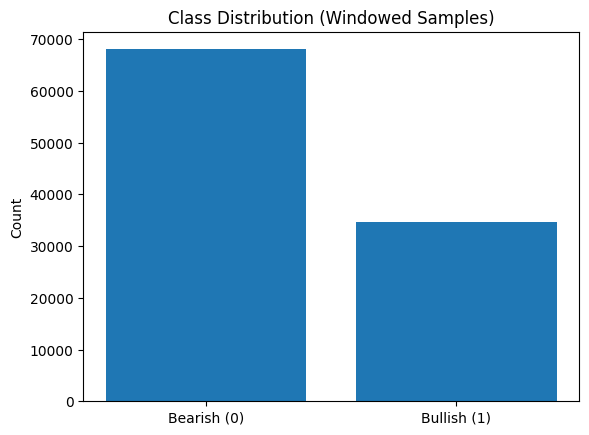

In [ ]:
# Class distribution (Bullish Vs Bearish)
y_cls = np.load("/content/lstm_ready/y_cls.npy")  # 0=Bearish, 1=Bullish

counts = {0: int((y_cls==0).sum()), 1: int((y_cls==1).sum())}
total  = len(y_cls)
perc0  = 100.0 * counts[0] / total if total else 0.0
perc1  = 100.0 * counts[1] / total if total else 0.0

print("Class counts (windowed samples):")
print({"Bearish (0)": counts[0], "Bullish (1)": counts[1]})
print("\nClass percentages (windowed samples):")
print({"Bearish (0)": round(perc0,2), "Bullish (1)": round(perc1,2)})

# Optional: bar chart
import matplotlib.pyplot as plt
plt.figure()
plt.bar(["Bearish (0)", "Bullish (1)"], [counts[0], counts[1]])
plt.title("Class Distribution (Windowed Samples)")
plt.ylabel("Count")
plt.show()

In [ ]:
# Check for missing or null Values


CSV_PATH = "/content/lstm_ready/full_hourly_dataset.csv"
df = pd.read_csv(CSV_PATH)

# 1) Per-column null counts and percentages
null_counts = df.isna().sum().sort_values(ascending=False)
null_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False)
summary = pd.DataFrame({"null_count": null_counts, "null_%": null_pct})
print("Nulls by column:")
print(summary)

# 2) Rows that contain ANY null
rows_with_any_null = df.isna().any(axis=1).sum()
print("\nRows with ANY null:", rows_with_any_null, "out of", len(df))

# 3) Peek at a few problematic rows (if any)
if rows_with_any_null:
    print("\nSample rows with nulls:")
    display(df[df.isna().any(axis=1)].head(10))




Nulls by column:
                   null_count  null_%
datetime                    0     0.0
symbol                      0     0.0
open                        0     0.0
high                        0     0.0
low                         0     0.0
close                       0     0.0
volume                      0     0.0
sentiment_shifted           0     0.0
future_close                0     0.0
future_ret_4h               0     0.0
target_updown               0     0.0

Rows with ANY null: 0 out of 114952


Feature columns: ['open', 'high', 'low', 'close', 'volume', 'sentiment_shifted']

Outlier summary (IQR rule):
          feature        q1            q3           iqr   lower_bound  upper_bound  outliers  outlier_%
sentiment_shifted  0.000000      0.000000      0.000000  0.000000e+00 0.000000e+00     18003  15.661320
           volume  0.000000 705027.000000 705027.000000 -1.057540e+06 1.762568e+06     14460  12.579163
             high 58.310001    214.576248    156.266247 -1.760894e+02 4.489756e+02     12484  10.860185
            close 57.870000    212.739479    154.869479 -1.744342e+02 4.450437e+02     12465  10.843656
             open 57.880000    212.729996    154.849996 -1.743950e+02 4.450050e+02     12454  10.834087
              low 57.400000    210.596000    153.196000 -1.723940e+02 4.403900e+02     12357  10.749704

Rows with ANY outlier across features: 36897 of 114952


/tmp/ipython-input-2135320931.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(feat_df[col].dropna(), vert=True, labels=[col], showfliers=True)
/tmp/ipython-input-2135320931.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(feat_df[col].dropna(), vert=True, labels=[col], showfliers=True)
/tmp/ipython-input-2135320931.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(feat_df[col].dropna(), vert=True, labels=[col], showfliers=True)
/tmp/ipython-input-2135320931.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotl

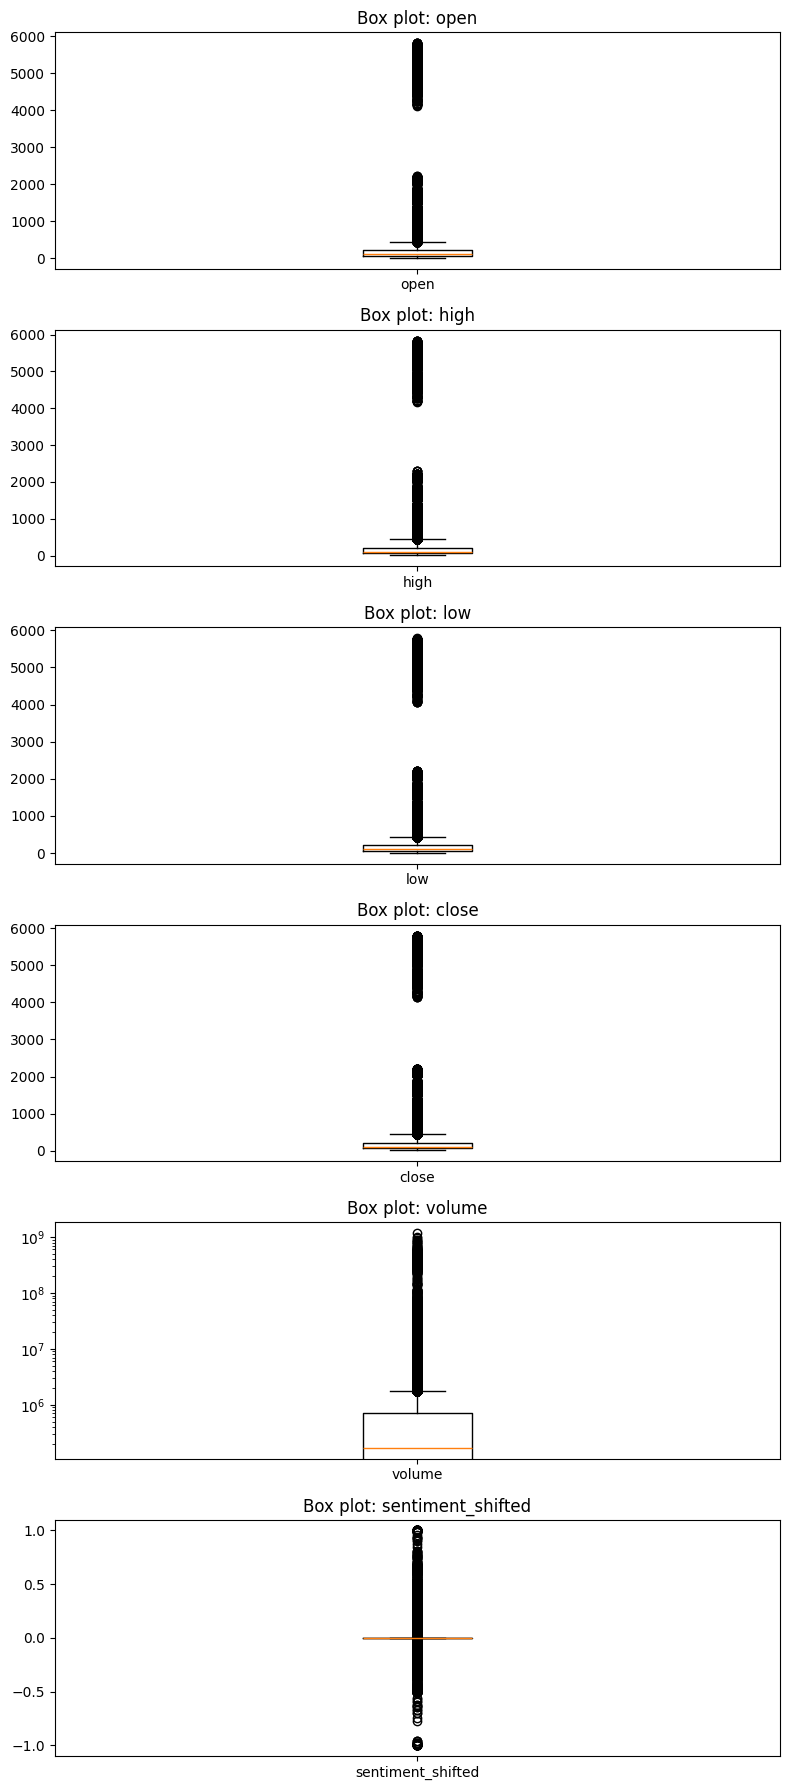

In [ ]:
# checking for outliers

# ---- keep only feature columns (drop targets & non-features) ----
drop_cols = [c for c in ["target_updown", "future_ret_4h", "future_close", "datetime", "symbol"] if c in df.columns]
feat_df = df.drop(columns=drop_cols, errors="ignore").select_dtypes(include=[np.number])

print("Feature columns:", list(feat_df.columns))

# ---- Outlier summary by IQR rule (per column) ----
rows = []
for col in feat_df.columns:
    s = feat_df[col].dropna()
    q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
    lo = q1 - 1.5 * iqr; hi = q3 + 1.5 * iqr
    n_out = int(((s < lo) | (s > hi)).sum())
    rows.append({
        "feature": col,
        "q1": q1, "q3": q3, "iqr": iqr,
        "lower_bound": lo, "upper_bound": hi,
        "outliers": n_out,
        "outlier_%": 100.0 * n_out / max(len(s), 1)
    })

outlier_summary = pd.DataFrame(rows).sort_values("outlier_%", ascending=False)
print("\nOutlier summary (IQR rule):")
print(outlier_summary.to_string(index=False))

# Rows containing ANY outlier across features (for inspection)
any_outlier_mask = pd.Series(False, index=feat_df.index)
for col in feat_df.columns:
    s = feat_df[col]
    q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
    lo = q1 - 1.5 * iqr; hi = q3 + 1.5 * iqr
    any_outlier_mask |= (s < lo) | (s > hi)

print("\nRows with ANY outlier across features:", int(any_outlier_mask.sum()), "of", len(feat_df))

# ---- Box plots (one per feature) ----
n = len(feat_df.columns)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 3*n))
if n == 1:
    axes = [axes]

for ax, col in zip(axes, feat_df.columns):
    ax.boxplot(feat_df[col].dropna(), vert=True, labels=[col], showfliers=True)
    ax.set_title(f"Box plot: {col}")
    # Optional: log-scale for heavy-tailed columns like volume
    if col.lower() == "volume":
        ax.set_yscale("log")

plt.tight_layout()
plt.show()

Correlation matrix (rounded):
                    open   high    low  close  volume  sentiment_shifted
open               1.000  1.000  1.000  1.000   0.276              0.024
high               1.000  1.000  1.000  1.000   0.276              0.024
low                1.000  1.000  1.000  1.000   0.276              0.024
close              1.000  1.000  1.000  1.000   0.276              0.024
volume             0.276  0.276  0.276  0.276   1.000              0.009
sentiment_shifted  0.024  0.024  0.024  0.024   0.009              1.000


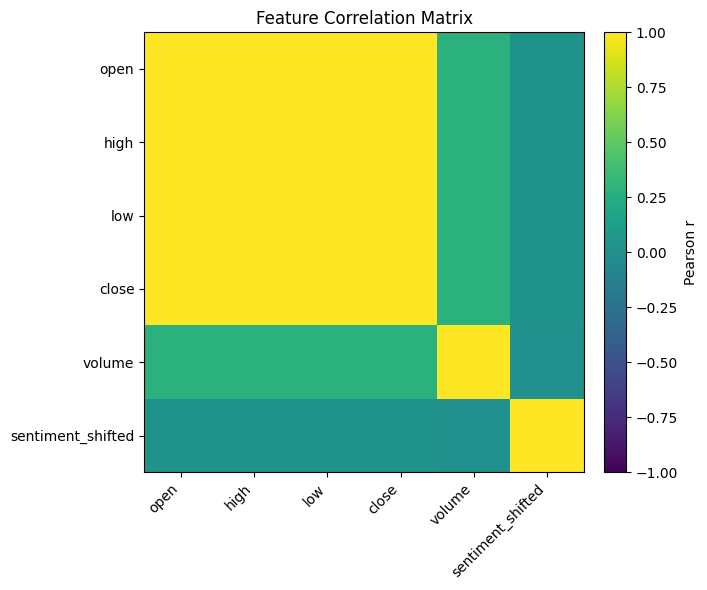

In [ ]:
# compute correlation Matrix

drop_cols = ["datetime", "symbol", "target_updown", "future_ret_4h", "future_close"]
feat_df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")



# Ensure numeric + handle NaNs/Infs
feat_df = feat_df.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# Pearson correlation
corr = feat_df.corr(method="pearson")

print("Correlation matrix (rounded):")
print(corr.round(3))


fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

# Tick labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Pearson r")

ax.set_title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

open, high, low, close are closely correlated with target. Volume has weak positive correlation. Sentiment score has almost zero correlation when compared to others that means it is independent of price or volume.

In [10]:
def set_seed(seed):

    torch.manual_seed(seed)      # Set PyTorch's random seed
    np.random.seed(seed)         # Set NumPy's random seed

# Make CUDA (GPU) operations deterministic to ensure repeatable results
torch.backends.cudnn.deterministic = True

# Apply the seed value (commonly used default)
set_seed(42)


In [9]:
# This selects the compute device: use GPU ('cuda') if available,
# otherwise fall back to CPU. This ensures compatibility on all systems.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:

def run_epoch(
    model, optimizer, data_loader, loss_func, device, results,
    score_funcs=None, prefix="", desc=None,
    task_type="classification"  # "classification" or "regression"
):
    """
    Runs one full epoch (training or evaluation).

    Args:
        model: torch.nn.Module
        optimizer: torch.optim.Optimizer
        data_loader: DataLoader
        loss_func: torch.nn loss function
        device: torch.device
        results: dict to store metrics across epochs
        score_funcs: dict of metric functions {name: func(y_true, y_pred)}
        prefix: str, prefix for metric keys ("train" or "val")
        desc: str, description for tqdm progress bar
        task_type: str, "classification" or "regression"
    """
    if score_funcs is None:
        score_funcs = {}

    running_loss = []
    y_true_all = []
    y_pred_all = []
    start = time.time()

    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        # Move to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Reset gradients before forward pass
        if model.training:
            optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_func(outputs, labels)

        # Backward + optimize (training mode only)
        if model.training:
            loss.backward()
            optimizer.step()

        # Record loss
        running_loss.append(loss.item())

        # Collect preds for metrics
        if len(score_funcs) > 0:
            if task_type == "classification":
                # Multi-class vs binary
                if outputs.shape[1] > 1:
                    preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()
                    preds = np.argmax(preds, axis=1)
                    labels_np = labels.detach().cpu().numpy()
                else:
                    preds = torch.sigmoid(outputs).detach().cpu().numpy()
                    preds = (preds >= 0.5).astype(int)  # threshold default
                    labels_np = labels.detach().cpu().numpy()
            else:  # regression
                preds = outputs.detach().cpu().numpy()
                labels_np = labels.detach().cpu().numpy()

            y_true_all.extend(labels_np.tolist())
            y_pred_all.extend(preds.tolist())

    # End time
    end = time.time()

    # Store average loss
    results[prefix + " loss"].append(np.mean(running_loss))

    # Store metrics
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append(score_func(y_true_all, y_pred_all))
        except Exception:
            results[prefix + " " + name].append(float("NaN"))

    return end - start


In [11]:
def train_network(
    model, loss_func, train_loader, val_loader=None, test_loader=None,
    score_funcs=None, epochs=50, device="cpu", checkpoint_file=None,
    lr_schedule=None, optimizer=None, disable_tqdm=False, task_type="classification"
):
    import pandas as pd
    import torch
    from tqdm import tqdm

    score_funcs = score_funcs or {}

    # Track metrics
    to_track = ["epoch", "total time", "train loss"]
    if val_loader:  to_track.append("val loss")
    if test_loader: to_track.append("test loss")

    for metric in score_funcs:
        to_track.append("train " + metric)
        if val_loader: to_track.append("val " + metric)
        if test_loader: to_track.append("test " + metric)

    results = {key: [] for key in to_track}
    total_train_time = 0

    # Optimizer default
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters())

    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        # Training
        model.train()
        total_train_time += run_epoch(
            model, optimizer, train_loader, loss_func,
            device, results, score_funcs, prefix="train",
            desc=f"Training (Epoch {epoch+1})", task_type=task_type
        )

        results["epoch"].append(epoch)
        results["total time"].append(total_train_time)

        # Validation
        if val_loader:
            model.eval()
            with torch.no_grad():
                run_epoch(
                    model, optimizer, val_loader, loss_func,
                    device, results, score_funcs, prefix="val",
                    desc=f"Validating (Epoch {epoch+1})", task_type=task_type
                )

        # LR scheduler
        if lr_schedule:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()

        # Testing
        if test_loader:
            model.eval()
            with torch.no_grad():
                run_epoch(
                    model, optimizer, test_loader, loss_func,
                    device, results, score_funcs, prefix="test",
                    desc=f"Testing (Epoch {epoch+1})", task_type=task_type
                )

        # Save checkpoint
        if checkpoint_file:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results': results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)


In [12]:

# Read the CSV file
dff = pd.read_csv('/content/drive/MyDrive/full_hourly_dataset.csv')



In [13]:



# 1) pick features + label
FEATURE_COLS = [c for c in ["close", "volume", "sentiment_shifted"] if c in dff.columns]
if not FEATURE_COLS:  # fallback: all numeric except obvious non-features
    drop_cols = {"future_return_4h", "target_updown", "datetime", "symbol", "tickr"}
    FEATURE_COLS = [c for c in dff.select_dtypes(include=[np.number]).columns if c not in drop_cols]

# label: prefer explicit target if present, else derive from future_return_4h
if "target_updown" in dff.columns:
    label = dff["target_updown"].astype(int).to_numpy()
else:
    assert "future_return_4h" in dff.columns, "Need target_updown or future_return_4h"
    label = (dff["future_return_4h"].to_numpy() > 0).astype(int)

features = dff[FEATURE_COLS].to_numpy(dtype=np.float32)

# 2) robust scale the entire feature matrix
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features).astype(np.float32)

# 3) train/test split (stratified)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
(train_index, test_index), = splitter.split(features_scaled, label)

X_train_full, X_test = features_scaled[train_index], features_scaled[test_index]
y_train_full, y_test  = label[train_index], label[test_index]

# 4) train/val split (stratified) from the training fold
val_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
(train_idx, val_idx), = val_splitter.split(X_train_full, y_train_full)

X_train, y_train = X_train_full[train_idx], y_train_full[train_idx]
X_val,   y_val   = X_train_full[val_idx],  y_train_full[val_idx]

# 5)  shapes + class distributions
print("Shapes  | X_train:", X_train.shape, "| X_val:", X_val.shape, "| X_test:", X_test.shape)
print("Features used:", FEATURE_COLS)
print("Train class distribution:", Counter(y_train))
print("Val   class distribution:", Counter(y_val))
print("Test  class distribution:", Counter(y_test))


Shapes  | X_train: (73568, 3) | X_val: (18393, 3) | X_test: (22991, 3)
Features used: ['close', 'volume', 'sentiment_shifted']
Train class distribution: Counter({np.int64(0): 49038, np.int64(1): 24530})
Val   class distribution: Counter({np.int64(0): 12260, np.int64(1): 6133})
Test  class distribution: Counter({np.int64(0): 15325, np.int64(1): 7666})


In [14]:

import torch
from torch.utils.data import TensorDataset

# Compat: if you used *_final names, map them back
if 'X_train' not in globals() and 'X_train_final' in globals():
    X_train, y_train = X_train_final, y_train_final
    X_val,   y_val   = X_val_final,   y_val_final

# Convert to tensors
features_train_tensor = torch.tensor(X_train, dtype=torch.float32)
features_val_tensor   = torch.tensor(X_val,   dtype=torch.float32)
features_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)

labels_train_tensor = torch.tensor(np.asarray(y_train), dtype=torch.long)
labels_val_tensor   = torch.tensor(np.asarray(y_val),   dtype=torch.long)
labels_test_tensor  = torch.tensor(np.asarray(y_test),  dtype=torch.long)

# Wrap in TensorDatasets
train_dataset = TensorDataset(features_train_tensor, labels_train_tensor)
val_dataset   = TensorDataset(features_val_tensor,   labels_val_tensor)
test_dataset  = TensorDataset(features_test_tensor,  labels_test_tensor)

# Sizes
print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))


Train set size: 73568
Validation set size: 18393
Test set size: 22991


In [15]:
# Batch sizes + DataLoaders
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
import torch

# Batch sizes
train_batch_size = 32
val_batch_size   = 32
test_batch_size  = 16

# GPU-friendly loader kwargs
loader_kwargs = {"num_workers": 2, "pin_memory": True} if torch.cuda.is_available() else {}

# DataLoaders (assumes you already created train_dataset, val_dataset, test_dataset)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_dataset,   batch_size=val_batch_size,   shuffle=False, **loader_kwargs)
test_loader  = DataLoader(test_dataset,  batch_size=test_batch_size,  shuffle=False, **loader_kwargs)

# quick sanity check
for name, dl in [("train", train_loader), ("val", val_loader), ("test", test_loader)]:
    try:
        xb, yb = next(iter(dl))
        print(f"{name}: batch {tuple(xb.shape)} labels {tuple(yb.shape)}")
    except StopIteration:
        print(f"{name}: dataset is empty 🤷")


train: batch (32, 3) labels (32,)
val: batch (32, 3) labels (32,)
test: batch (16, 3) labels (16,)


In [16]:
# ===== Multitask LSTM training from `dff` (chronological split, train-only scaling, sequence windows) =====
# - Pulls features/labels from your DataFrame `dff`
# - Builds [B,T,F] windows for LSTM
# - Handles class imbalance (WeightedRandomSampler + class-weighted Focal Loss)
# - Monitors PR-AUC; chooses a balanced threshold from validation each epoch
# =========================================================================================================

import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             precision_score, recall_score, roc_auc_score,
                             mean_squared_error, mean_absolute_error,
                             roc_curve, precision_recall_curve, average_precision_score)

# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Config
T_WINDOW   = 48     # timesteps per window
HORIZON    = 0      # label offset from the last step (0 = label at last step)
VAL_FRACT  = 0.15   # 15% validation (chronological)
TEST_FRACT = 0.15   # 15% test (chronological)
BATCH_TR   = 256
BATCH_EVAL = 256
LR         = 1e-3
WD         = 1e-4
HIDDEN     = 96
LAYERS     = 2
DROPOUT    = 0.1
ALPHA_CLS  = 1.0    # weight for classification loss
BETA_REG   = 0.5    # weight for regression loss
EPOCHS     = 20

#  1) Pull data from your `dff`
assert "dff" in globals(), "Expected a pandas DataFrame `dff` in memory."

# Sort chronologically to avoid leakage
for time_col in ["datetime", "timestamp", "date", "time"]:
    if time_col in dff.columns:
        dff = dff.sort_values(time_col).reset_index(drop=True)
        break  # use the first time-like column found

# Choose feature columns
FEATURE_COLS = [c for c in ["close", "volume", "sentiment_shifted"] if c in dff.columns]
if not FEATURE_COLS:
    # fallback: all numeric except obvious label/ID columns
    drop_cols = {"future_return_4h", "target_updown", "symbol", "tickr", "id"}
    FEATURE_COLS = [c for c in dff.select_dtypes(include=[np.number]).columns if c not in drop_cols]

# Classification label
if "target_updown" in dff.columns:
    y_cls_all = dff["target_updown"].astype(np.int64).to_numpy()
else:
    assert "future_return_4h" in dff.columns, "Need `target_updown` or `future_return_4h` in `dff`."
    y_cls_all = (dff["future_return_4h"].to_numpy() > 0).astype(np.int64)

# Regression target
if "sentiment_shifted" in dff.columns:
    y_reg_all = dff["sentiment_shifted"].astype(np.float32).to_numpy()
else:
    y_reg_all = dff["future_return_4h"].astype(np.float32).to_numpy()

X_all = dff[FEATURE_COLS].astype(np.float32).to_numpy()

# Drop rows with NaNs/Infs (keeps alignment)
mask = np.isfinite(X_all).all(1) & np.isfinite(y_cls_all) & np.isfinite(y_reg_all)
X_all, y_cls_all, y_reg_all = X_all[mask], y_cls_all[mask], y_reg_all[mask]
N = len(X_all)
assert N > (T_WINDOW + HORIZON + 10), "Not enough rows for windowing—reduce T_WINDOW or HORIZON."

#  2) Chronological split (train / val / test)
i_test = int(N * (1 - TEST_FRACT))
i_val  = int(i_test * (1 - VAL_FRACT))  # val is a fraction of (train+val)
# splits: [0 : i_val) -> train, [i_val : i_test) -> val, [i_test : N) -> test
X_train_raw, y_train_cls_raw, y_train_reg_raw = X_all[:i_val],  y_cls_all[:i_val],  y_reg_all[:i_val]
X_val_raw,   y_val_cls_raw,   y_val_reg_raw   = X_all[i_val:i_test], y_cls_all[i_val:i_test], y_reg_all[i_val:i_test]
X_test_raw,  y_test_cls_raw,  y_test_reg_raw  = X_all[i_test:], y_cls_all[i_test:], y_reg_all[i_test:]

print(f"Chrono splits → train: {len(X_train_raw)}, val: {len(X_val_raw)}, test: {len(X_test_raw)}")

#  3) Scale on TRAIN only
scaler = RobustScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw).astype(np.float32)
X_val   = scaler.transform(X_val_raw).astype(np.float32)
X_test  = scaler.transform(X_test_raw).astype(np.float32)

#  4) Build [B,T,F] windows per split
def make_windows(X, yc, yr, T=48, horizon=0):
    """
    Returns:
      Xw:  [M, T, F]
      ycw: [M]
      yrw: [M]
    Uses label at index (start+T-1+horizon).
    """
    M = len(X) - T - horizon + 1
    if M <= 0:
        return np.empty((0, T, X.shape[1]), np.float32), np.empty((0,), np.int64), np.empty((0,), np.float32)
    Xw  = np.zeros((M, T, X.shape[1]), dtype=np.float32)
    ycw = np.zeros((M,), dtype=np.int64)
    yrw = np.zeros((M,), dtype=np.float32)
    for i in range(M):
        start = i
        end   = i + T
        tgt_i = end - 1 + horizon
        Xw[i]  = X[start:end]
        ycw[i] = int(yc[tgt_i])
        yrw[i] = float(yr[tgt_i])
    return Xw, ycw, yrw

Xtr, ytr_cls, ytr_reg = make_windows(X_train, y_train_cls_raw, y_train_reg_raw, T=T_WINDOW, horizon=HORIZON)
Xva, yva_cls, yva_reg = make_windows(X_val,   y_val_cls_raw,   y_val_reg_raw,   T=T_WINDOW, horizon=HORIZON)
Xte, yte_cls, yte_reg = make_windows(X_test,  y_test_cls_raw,  y_test_reg_raw,  T=T_WINDOW, horizon=HORIZON)

print("Windowed shapes →",
      f"Xtr {Xtr.shape}, Xva {Xva.shape}, Xte {Xte.shape}")

# Class balance (train)
from collections import Counter
print("Train class distribution:", Counter(ytr_cls))
print("Val   class distribution:", Counter(yva_cls))
print("Test  class distribution:", Counter(yte_cls))

#  5) Tensors & Datasets
Xtr_t  = torch.tensor(Xtr,  dtype=torch.float32)
Xva_t  = torch.tensor(Xva,  dtype=torch.float32)
Xte_t  = torch.tensor(Xte,  dtype=torch.float32)
ytrc_t = torch.tensor(ytr_cls, dtype=torch.long)
yvac_t = torch.tensor(yva_cls, dtype=torch.long)
ytec_t = torch.tensor(yte_cls, dtype=torch.long)
ytrr_t = torch.tensor(ytr_reg, dtype=torch.float32)
yvar_t = torch.tensor(yva_reg, dtype=torch.float32)
yter_t = torch.tensor(yte_reg, dtype=torch.float32)

train_ds = TensorDataset(Xtr_t, ytrc_t, ytrr_t)
val_ds   = TensorDataset(Xva_t, yvac_t, yvar_t)
test_ds  = TensorDataset(Xte_t, ytec_t, yter_t)

#  6) Train-only balancing via WeightedRandomSampler
class_counts = np.bincount(ytr_cls.astype(int), minlength=2)
neg, pos = int(class_counts[0]), int(class_counts[1])

w_per_class = np.zeros(2, dtype=np.float32)
w_per_class[0] = 1.0 / max(neg, 1)
w_per_class[1] = 1.0 / max(pos, 1)
sample_weights = torch.tensor(w_per_class[ytr_cls.astype(int)], dtype=torch.float32)
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

#  7) DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_TR, sampler=sampler,
                          num_workers=2, pin_memory=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_EVAL, shuffle=False,
                          num_workers=2, pin_memory=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL, shuffle=False,
                          num_workers=2, pin_memory=True, drop_last=False)

#  8) Model
class MultiTaskLSTM(nn.Module):
    def __init__(self, input_size, hidden=96, layers=2, dropout=0.1, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden, num_layers=layers,
                            dropout=dropout if layers > 1 else 0.0,
                            batch_first=True, bidirectional=bidirectional)
        out_dim = hidden * (2 if bidirectional else 1)
        self.cls_head = nn.Linear(out_dim, 2)
        self.reg_head = nn.Linear(out_dim, 1)
    def forward(self, x):            # x: [B,T,F]
        out, _ = self.lstm(x)        # [B,T,H*dirs]
        h = out[:, -1, :]            # last step
        logits = self.cls_head(h)    # [B,2]
        reg    = self.reg_head(h).squeeze(1)  # [B]
        return logits, reg

model = MultiTaskLSTM(input_size=Xtr.shape[2], hidden=HIDDEN, layers=LAYERS, dropout=DROPOUT,
                      bidirectional=False).to(device)

# 9) Losses, Optimizer, Scheduler
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.5, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, weight=self.alpha, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp_min(1e-8)
        loss = ((1.0 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

alpha = torch.tensor([1.0 / max(neg,1), 1.0 / max(pos,1)], dtype=torch.float32, device=device)
cls_loss = FocalLoss(alpha=alpha, gamma=1.5).to(device)     # class-weighted focal
reg_loss = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                       factor=0.5, patience=2, verbose=True)

#  10) Helpers: eval + balanced threshold
def best_balanced_threshold(y_true, probs):
    if len(np.unique(y_true)) < 2:
        return 0.5
    fpr, tpr, thr = roc_curve(y_true, probs)
    tnr = 1.0 - fpr
    idx = int(np.argmin(np.abs(tpr - tnr)))
    return float(np.clip(thr[idx], 0.05, 0.95))

@torch.no_grad()
def evaluate(loader, threshold=0.5, want_curves=False):
    model.eval()
    total, n = 0.0, 0
    probs_all, ytrue_all = [], []
    rp_all, rt_all = [], []
    for xb, yb_cls, yb_reg in loader:
        xb, yb_cls, yb_reg = xb.to(device), yb_cls.to(device), yb_reg.to(device)
        logits, yhat_r = model(xb)
        loss = ALPHA_CLS*cls_loss(logits, yb_cls) + BETA_REG*reg_loss(yhat_r, yb_reg)
        total += loss.item() * xb.size(0); n += xb.size(0)
        probs_all.append(torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy())
        ytrue_all.append(yb_cls.detach().cpu().numpy())
        rp_all.append(yhat_r.detach().cpu().numpy())
        rt_all.append(yb_reg.detach().cpu().numpy())

    avg_loss = total / max(n,1)
    probs = np.concatenate(probs_all) if probs_all else np.array([])
    ytrue = np.concatenate(ytrue_all).astype(int) if ytrue_all else np.array([], dtype=int)
    yhat  = (probs >= threshold).astype(int) if probs.size else np.array([], dtype=int)

    if ytrue.size and len(np.unique(ytrue)) == 2:
        acc  = accuracy_score(ytrue, yhat)
        bacc = balanced_accuracy_score(ytrue, yhat)
        f1   = f1_score(ytrue, yhat, zero_division=0)
        prec = precision_score(ytrue, yhat, zero_division=0)
        rec  = recall_score(ytrue, yhat, zero_division=0)
        auc  = roc_auc_score(ytrue, probs)
        prec_curve, rec_curve, pr_thr = precision_recall_curve(ytrue, probs)
        ap   = average_precision_score(ytrue, probs)
    else:
        acc = bacc = f1 = prec = rec = auc = ap = float("nan")
        prec_curve = rec_curve = pr_thr = np.array([])

    rp = np.concatenate(rp_all) if rp_all else np.array([])
    rt = np.concatenate(rt_all) if rt_all else np.array([])
    rmse = math.sqrt(mean_squared_error(rt, rp)) if rt.size else float("nan")
    mae  = mean_absolute_error(rt, rp) if rt.size else float("nan")

    out = {"loss": avg_loss, "acc": acc, "bacc": bacc, "f1": f1, "prec": prec, "rec": rec, "auc": auc,
           "rmse": rmse, "mae": mae, "ap": ap, "probs": probs, "ytrue": ytrue}
    if want_curves:
        out.update({"prec_curve": prec_curve, "rec_curve": rec_curve, "pr_thr": pr_thr})
    return out

def train_one_epoch(loader):
    model.train()
    total, n = 0.0, 0
    for xb, yb_cls, yb_reg in loader:
        xb, yb_cls, yb_reg = xb.to(device), yb_cls.to(device), yb_reg.to(device)
        optimizer.zero_grad()
        logits, yhat_r = model(xb)
        loss = ALPHA_CLS*cls_loss(logits, yb_cls) + BETA_REG*reg_loss(yhat_r, yb_reg)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item() * xb.size(0); n += xb.size(0)
    return total / max(n,1)

#  11) Train
best_val = float("inf")
best_state = None
best_thresh = 0.5
train_losses, val_losses, val_ap_hist = [], [], []

for ep in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(train_loader)
    va = evaluate(val_loader, threshold=best_thresh, want_curves=True)

    # choose a balanced threshold from current val probs
    thr_bal = best_balanced_threshold(va["ytrue"], va["probs"])
    best_thresh = thr_bal  # for reporting / next epoch

    train_losses.append(tr_loss); val_losses.append(va["loss"]); val_ap_hist.append(va["ap"])
    scheduler.step(va["loss"])

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} | val {va['loss']:.4f} | "
          f"val bAcc {va['bacc']:.3f} | val F1 {va['f1']:.3f} | val AUC {va['auc']:.3f} | "
          f"val PR-AUC {va['ap']:.3f} | (balanced thr → {thr_bal:.2f})")

    if va["loss"] < best_val:
        best_val = va["loss"]
        best_state = {k: v.detach().cpu().clone() if isinstance(v, torch.Tensor) else v
                      for k, v in model.state_dict().items()}

# Restore best weights (by val loss)
if best_state is not None:
    model.load_state_dict(best_state)

print("\nTraining finished.")
print(f"Features used: {FEATURE_COLS}")
print(f"Final balanced threshold from validation: {best_thresh:.2f}")




Chrono splits → train: 83052, val: 14657, test: 17243
Windowed shapes → Xtr (83005, 48, 3), Xva (14610, 48, 3), Xte (17196, 48, 3)
Train class distribution: Counter({np.int64(0): 54538, np.int64(1): 28467})
Val   class distribution: Counter({np.int64(0): 10115, np.int64(1): 4495})
Test  class distribution: Counter({np.int64(0): 11875, np.int64(1): 5321})


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | train 0.0013 | val 0.0000 | val bAcc 0.500 | val F1 0.471 | val AUC 0.743 | val PR-AUC 0.468 | (balanced thr → 0.56)
Epoch 02 | train 0.0001 | val 0.0000 | val bAcc 0.641 | val F1 0.511 | val AUC 0.747 | val PR-AUC 0.471 | (balanced thr → 0.56)
Epoch 03 | train 0.0000 | val 0.0000 | val bAcc 0.683 | val F1 0.571 | val AUC 0.750 | val PR-AUC 0.474 | (balanced thr → 0.56)
Epoch 04 | train 0.0000 | val 0.0000 | val bAcc 0.668 | val F1 0.552 | val AUC 0.751 | val PR-AUC 0.475 | (balanced thr → 0.56)
Epoch 05 | train 0.0000 | val 0.0000 | val bAcc 0.659 | val F1 0.538 | val AUC 0.752 | val PR-AUC 0.476 | (balanced thr → 0.55)
Epoch 06 | train 0.0000 | val 0.0000 | val bAcc 0.702 | val F1 0.594 | val AUC 0.753 | val PR-AUC 0.476 | (balanced thr → 0.58)
Epoch 07 | train 0.0000 | val 0.0000 | val bAcc 0.711 | val F1 0.604 | val AUC 0.754 | val PR-AUC 0.477 | (balanced thr → 0.61)
Epoch 08 | train 0.0000 | val 0.0000 | val bAcc 0.573 | val F1 0.361 | val AUC 0.754 | val PR-AUC 0.478 

In [17]:
#  Eval: sweep thresholds; choose by Max TNR with min recall; then test
import numpy as np, math, torch, pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error
)

#  Selection rule & constraint
FINAL_RULE = "tnr_min_rec"   # options left available: "tnr_min_rec", "youden", "bacc"
MIN_REC    = 0.30            # <-- minimum recall (TPR) for class 1 you require (tune this)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

@torch.no_grad()
def collect_all(loader):
    probs_all, ytrue_all = [], []
    r_pred_all, r_true_all = [], []
    # Works whether your dataset yields (X, y_cls, y_reg) or (X, y_cls) only
    for batch in loader:
        xb, yb_cls = batch[0], batch[1]
        xb = xb.to(device)
        logits, yhat_r = model(xb)
        probs_all.append(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())
        ytrue_all.append(yb_cls.cpu().numpy())
        if len(batch) >= 3:
            yb_reg = batch[2]
            r_pred_all.append(yhat_r.cpu().numpy())
            r_true_all.append(yb_reg.cpu().numpy())
    probs = np.concatenate(probs_all) if probs_all else np.array([])
    ytrue = np.concatenate(ytrue_all).astype(int) if ytrue_all else np.array([], dtype=int)
    r_pred = np.concatenate(r_pred_all) if r_pred_all else np.array([])
    r_true = np.concatenate(r_true_all) if r_true_all else np.array([])
    return probs, ytrue, r_pred, r_true

#  1) Sweep thresholds on VALIDATION
val_probs, val_true, _, _ = collect_all(val_loader)
THRESHOLDS = np.round(np.arange(0.05, 0.96, 0.01), 2)

rows = []
for th in THRESHOLDS:
    yhat = (val_probs >= th).astype(int)

    tp = int(((yhat == 1) & (val_true == 1)).sum())
    tn = int(((yhat == 0) & (val_true == 0)).sum())
    fp = int(((yhat == 1) & (val_true == 0)).sum())   # bears → bulls (false positives)
    fn = int(((yhat == 0) & (val_true == 1)).sum())

    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0   # TPR (recall for bulls)
    tnr  = tn / (tn + fp) if (tn + fp) > 0 else 0.0   # specificity (for bears)
    bacc = (rec + tnr) / 2.0
    acc  = (tp + tn) / max(len(val_true), 1)
    f1   = (2*prec*rec / (prec + rec)) if (prec + rec) > 0 else 0.0
    youden = rec + tnr - 1.0

    rows.append({
        "threshold": th,
        "acc": acc, "bacc": bacc, "youden": youden,
        "prec": prec, "rec": rec, "tnr": tnr, "f1": f1,
        "tp": tp, "tn": tn, "fp": fp, "fn": fn
    })

sweep_df = pd.DataFrame(rows)

#  Best thresholds by rules
best_th_bacc   = float(sweep_df.sort_values(["bacc","youden"], ascending=False).iloc[0]["threshold"])
best_th_youden = float(sweep_df.sort_values(["youden","bacc"], ascending=False).iloc[0]["threshold"])

# Maximize TNR subject to a minimum recall constraint
cand = sweep_df[sweep_df["rec"] >= MIN_REC].sort_values(["tnr","bacc","youden","prec"], ascending=False)
if not cand.empty:
    best_th_tnr_minrec = float(cand.iloc[0]["threshold"])
else:
    # if no threshold meets MIN_REC, fall back to pure TNR max
    best_th_tnr_minrec = float(sweep_df.sort_values(["tnr","bacc","youden","prec"], ascending=False).iloc[0]["threshold"])

print("Best thresholds found on validation:")
print(f"  • Balanced Accuracy (bAcc): {best_th_bacc:.2f}")
print(f"  • Youden's J              : {best_th_youden:.2f}")
print(f"  • Max TNR w/ min recall≥{MIN_REC:.2f}: {best_th_tnr_minrec:.2f}")

print("\nTop 5 by Youden's J:")
print(sweep_df.sort_values("youden", ascending=False).head()[["threshold","youden","tnr","rec","bacc","prec"]])

print(f"\nTop 5 by TNR subject to recall≥{MIN_REC:.2f}:")
show = cand if not cand.empty else sweep_df.sort_values("tnr", ascending=False)
print(show.head()[["threshold","tnr","rec","bacc","youden","prec"]])

#  Choose the rule to use on TEST
if FINAL_RULE == "tnr_min_rec":
    best_th = best_th_tnr_minrec
elif FINAL_RULE == "youden":
    best_th = best_th_youden
elif FINAL_RULE == "bacc":
    best_th = best_th_bacc
else:
    raise ValueError("FINAL_RULE must be one of: 'tnr_min_rec', 'youden', 'bacc'")

print(f"\n Chosen threshold (rule = {FINAL_RULE}): {best_th:.2f}")

#  2) Evaluate on TEST with chosen threshold
test_probs, test_true, test_r_pred, test_r_true = collect_all(test_loader)
test_hat = (test_probs >= best_th).astype(int)

print(f"\n Classification report @ threshold {best_th:.2f} (rule = {FINAL_RULE})")
print(classification_report(test_true, test_hat, digits=3))

acc  = accuracy_score(test_true, test_hat)
bacc = balanced_accuracy_score(test_true, test_hat)
f1   = f1_score(test_true, test_hat, zero_division=0)
prec = precision_score(test_true, test_hat, zero_division=0)
rec  = recall_score(test_true, test_hat, zero_division=0)
auc  = roc_auc_score(test_true, test_probs) if len(np.unique(test_true)) == 2 else float("nan")
cm   = confusion_matrix(test_true, test_hat)

rmse = math.sqrt(mean_squared_error(test_r_true, test_r_pred)) if test_r_true.size else float("nan")
mae  = mean_absolute_error(test_r_true, test_r_pred) if test_r_true.size else float("nan")

print("\nTest metrics:")
print(f"Acc {acc:.3f} | bAcc {bacc:.3f} | F1 {f1:.3f} | Prec {prec:.3f} | Rec {rec:.3f} | AUC {auc:.3f}")
print(f"Regression: RMSE {rmse:.4f} | MAE {mae:.4f}")
print("Confusion matrix (rows=true [0,1], cols=pred [0,1]):\n", cm)


Best thresholds found on validation:
  • Balanced Accuracy (bAcc): 0.53
  • Youden's J              : 0.53
  • Max TNR w/ min recall≥0.30: 0.66

Top 5 by Youden's J:
    threshold    youden       tnr       rec      bacc      prec
48       0.53  0.494187  0.536233  0.957953  0.747093  0.478604
49       0.54  0.493519  0.538013  0.955506  0.746759  0.478925
50       0.55  0.493395  0.540781  0.952614  0.746698  0.479668
47       0.52  0.492901  0.534058  0.958843  0.746451  0.477668
46       0.51  0.491567  0.532279  0.959288  0.745783  0.476833

Top 5 by TNR subject to recall≥0.30:
    threshold       tnr       rec      bacc    youden      prec
61       0.66  0.832921  0.351279  0.592100  0.184201  0.483022
60       0.65  0.773604  0.464071  0.618837  0.237675  0.476691
59       0.64  0.721206  0.581535  0.651371  0.302741  0.481045
58       0.63  0.679189  0.672525  0.675857  0.351714  0.482291
57       0.62  0.640336  0.751279  0.695808  0.391615  0.481397

✅ Chosen threshold (rule = 